In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## Calculating correction to binding free energy considering aqueous pKa and binding of multiple states

$$ \Delta G_{bind} =\Delta G_{bind}^{N} + \Delta G_{corr}$$  

$$ \Delta G_{bind} =\Delta G_{bind}^{N} - RT\ln{\frac{1 + e^{-\frac{\Delta G_{bind}^{C} - \Delta G_{bind}^{N}}{RT}}10^{pK_a - pH}}{1 + 10^{pK_a - pH}}} $$  

In [2]:
def calc_correction_to_free_energy_of_binding(DDGs,  pH,  pKas):
    """
    This function calculates the free energy correction that needs to be added to the binding affinity 
    of the neutral state to account of a charged state contributing to the affinity considering pH and
    pKa. The calculation is done for 298 K.
    DDGs: np.array
         The difference between binding free enerfies of the charged and the neutral ligand
                 in units of kcal/mol.
                 DeltaDeltaG = DeltaG_charged - DeltaG_neutral
    pH : float
         pH of the solution
    pKas: np.array
         Aqueous pKa of the ligand
    """
    RT = 0.593 # kcal/mol
    
    # Save values in a list to be converted to Pandas Dataframe
    data_collection =[]
    
    # Iterate through DDG values to calculate free energy correction for each case
    for DDG in DDGs:
        #print("Calculation for DeltaG_C - DeltaG_N = {} ...".format(DDG))
        pH_array = np.repeat(pH, len(pKas))
        DDG_array = np.repeat(DDG, len(pKas))

        free_energy_correction = - RT * np.log( (1 + np.e**(-DDG/RT)* 10**(pKas - pH)) / (1 + 10**(pKas - pH)) )
        #print("free energy correction (kcal/mol):", free_energy_correction)

        # Arrange all the information in for the dataframe
        
        for i, corr in enumerate(free_energy_correction):
            data_collection.append({
                "$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$": DDG, 
                "pH": pH_array[i] , 
                "pKa": pKas[i], 
                "pH - pKa": pH_array[i] - pKas[i],
                "$\Delta G_{corr}$ (kcal/mol)": free_energy_correction[i]
            })

    df_corr = pd.DataFrame(data_collection)

    return df_corr 


class correction_to_free_energy_of_binding:
    
    def __init__(self, DDGs, pH, pKas):
        """
        This function calculates the free energy correction that needs to be added to the binding affinity 
        of the neutral state to account of a charged state contributing to the affinity considering pH and
        pKa. The calculation is done for 298 K.
        DDGs: np.array
             The difference between binding free enerfies of the charged and the neutral ligand
                     in units of kcal/mol.
                     DeltaDeltaG = DeltaG_charged - DeltaG_neutral
        pH : float
             pH of the solution
        pKas: np.array
             Aqueous pKa of the ligand
        """
        RT = 0.593 # kcal/mol
        
        # Save values in a list to be converted to Pandas Dataframe
        data_collection =[]

        # Iterate through DDG values to calculate free energy correction for each case
        for DDG in DDGs:
            #print("Calculation for DeltaG_C - DeltaG_N = {} ...".format(DDG))
            pH_array = np.repeat(pH, len(pKas))
            DDG_array = np.repeat(DDG, len(pKas))

            free_energy_correction = - RT * np.log( (1 + np.e**(-DDG/RT)* 10**(pKas - pH)) / (1 + 10**(pKas - pH)) )
            #print("free energy correction (kcal/mol):", free_energy_correction)

            # Arrange all the information in for the dataframe

            for i, corr in enumerate(free_energy_correction):
                data_collection.append({
                    "$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$": DDG, 
                    "pH": pH_array[i] , 
                    "pKa": pKas[i], 
                    "pH - pKa": pH_array[i] - pKas[i],
                    "$\Delta G_{corr}$ (kcal/mol)": free_energy_correction[i]
                })

        self.data = pd.DataFrame(data_collection)
    
    def calculate_correction_with_inaccurate_pKa(self, pKa_error):
        """Calculates free energy correction if pKa value is underestimated or overestimated"""
        RT = 0.593 # kcal/mol
        
        self.data["$\Delta G_{corr}$ error (kcal/mol)"] = np.NaN
        
        for i, row in enumerate(self.data.iterrows()):
            true_pKa = row[1]["pKa"]
            pred_pKa = true_pKa + pKa_error
            DDG = row[1]["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"]
            
            # Calculate free energy correction using the predicted pKa with error
            pred_free_energy_correction = - RT * np.log( (1 + np.e**(-DDG/RT)* 10**(pred_pKa - pH)) / (1 + 10**(pred_pKa - pH)) )
          
            # Save to dataframe
            self.data.loc[i, "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"] =  pred_free_energy_correction
            
        return self.data
    
    
    def calculate_correction_error_due_to_inaccurate_pKa(self, pKa_error):
        """Calculates error in the free energy correction if pKa value is underestimated or overestimated"""
        RT = 0.593 # kcal/mol
        
        self.data["$\Delta G_{corr}$ error (kcal/mol)"] = np.NaN
        
        for i, row in enumerate(self.data.iterrows()):
            true_pKa = row[1]["pKa"]
            pred_pKa = true_pKa + pKa_error
            DDG = row[1]["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"]
            true_free_energy_correction = row[1]["$\Delta G_{corr}$ (kcal/mol)"]
            
            # Calculate free energy correction using the predicted pKa with error
            pred_free_energy_correction = - RT * np.log( (1 + np.e**(-DDG/RT)* 10**(pred_pKa - pH)) / (1 + 10**(pred_pKa - pH)) )
            
            # Error in free energy correction value
            correction_error = pred_free_energy_correction - true_free_energy_correction
            
            # Save to dataframe
            self.data.loc[i, "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"] = correction_error
            
        return self.data
    
    
    def calculate_error_due_to_ignoring_correction(self):
        """What is the error in overall free energy of binding if we ignore the free energy correction 
        due to multiple charges states?"""
        
        self.data["$\Delta G_{corr}$ error (kcal/mol)"] = np.NaN
        
        for i, row in enumerate(self.data.iterrows()):
            true_free_energy_correction = row[1]["$\Delta G_{corr}$ (kcal/mol)"]
            pred_free_energy_correction = 0
            
            # Error in free energy correction value
            correction_error = pred_free_energy_correction - true_free_energy_correction
            
            # Save to dataframe
            self.data.loc[i, "$\Delta G_{bind}$ error if correction is ignored (kcal/mol)"] = correction_error
            
        return self.data
    
    
    def calc_error_difference_between_ignore_and_inaccurate_pKa(self):
        """How much is the error of ignorning multiple charge state correction compared to correction 
        with inaccurate pKa"""
        
        self.data["$\Delta G_{bind}$ error difference (ignore - inaccurate pKa)"] = np.NaN
        
        for i, row in enumerate(self.data.iterrows()):
            ignore_error = row[1]["$\Delta G_{bind}$ error if correction is ignored (kcal/mol)"]
            inaccurate_pKa_error = row[1]["$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"]
            
            error_diff = ignore_error - inaccurate_pKa_error
            
            # Save to dataframe
            self.data.loc[i, "$\Delta G_{bind}$ error difference (ignore - inaccurate pKa)"] = error_diff
            
        return self.data
            
        
            
        
        
        

def plot_free_energy_correction(data, x_label, y_label, DDGs, pH, figsize=False):
    """
    Free energy correction vs pKa plot
    """
    plt.close()
    
    # Color
    current_palette = sns.color_palette()
    error_color = sns.color_palette("GnBu_d")[0]
    
    # Plot style
    plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 16
    plt.tight_layout()
    bar_width = 0.45

    # If figsize is specified
    if figsize != False:
        plt.figure(figsize=figsize)

    #Iterate through DDG values to plot multiple datasets
    for i, DDG in enumerate(DDGs):
        
        # Select data based on DDG specified
        data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
        #print("data_1DDG.tail():", data_1DDG.tail())
        x = data_1DDG[x_label]
        y = data_1DDG[y_label]
    
        # Plot
        plt.plot(x, y, label = "DG_C - DG_N = {} kcal/mol".format(DDG), color=current_palette[i])
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title("Correction to free energy of binding")
    plt.show()

    
def plot_free_energy_correction_error(data, x_label, y_label, DDGs, pKa_error, figsize=False):
    """
    Free energy correction vs pKa plot
    """
    plt.close()
    
    # Color
    current_palette = sns.color_palette()
    error_color = sns.color_palette("GnBu_d")[0]
    
    # Plot style
    plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 16
    plt.tight_layout()
    bar_width = 0.45

    # If figsize is specified
    if figsize != False:
        plt.figure(figsize=figsize)

    #Iterate through DDG values to plot multiple datasets
    for i, DDG in enumerate(DDGs):
        
        # Select data based on DDG specified
        data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
        #print("data_1DDG.tail():", data_1DDG.tail())
        x = data_1DDG[x_label]
        y = data_1DDG[y_label]
    
        # Plot
        plt.plot(x, y, label = "DG_C - DG_N = {} kcal/mol".format(DDG), color=current_palette[i])
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0. -1.5)
    plt.legend()
    plt.title("Error in free energy correction due a pKa error of {}".format(pKa_error))

In [3]:
pH = 7.0
pKa_values=np.arange(3, 11.1, 0.1)
DDG_values=np.array([-1.0, -2.0, -3.0, -4.0])
#df_corr = calc_correction_to_free_energy_of_binding(DDGs = DDG_values, pH = pH, pKas = pKa_values)
correction = correction_to_free_energy_of_binding(DDGs = DDG_values, pH = pH, pKas = pKa_values)
correction.data

,$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$,$\Delta G_{corr}$ (kcal/mol),pH,pH - pKa,pKa
0,-1.0,-0.000261,7.0,4.0,3.0
1,-1.0,-0.000328,7.0,3.9,3.1
2,-1.0,-0.000413,7.0,3.8,3.2
3,-1.0,-0.000520,7.0,3.7,3.3
4,-1.0,-0.000655,7.0,3.6,3.4
5,-1.0,-0.000824,7.0,3.5,3.5
6,-1.0,-0.001037,7.0,3.4,3.6
7,-1.0,-0.001306,7.0,3.3,3.7
8,-1.0,-0.001643,7.0,3.2,3.8
9,-1.0,-0.002067,7.0,3.1,3.9


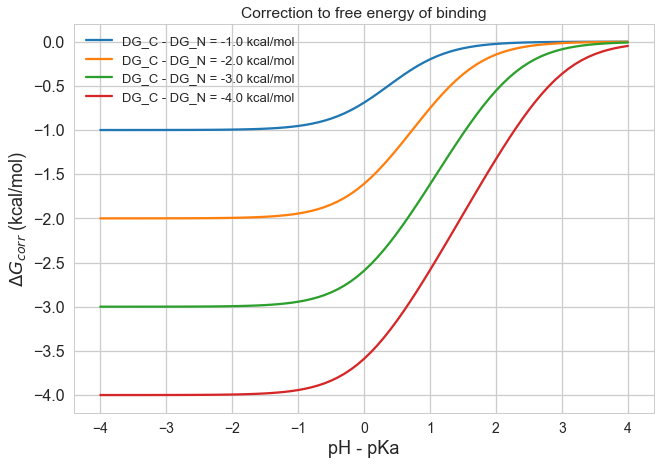

In [4]:
plot_free_energy_correction(data = correction.data, x_label = "pH - pKa", y_label = "$\Delta G_{corr}$ (kcal/mol)", 
                            DDGs = DDG_values, pH = pH, figsize = False)

## Effects of underestimating pKa by 1 unit

<Figure size 748.8x514.8 with 0 Axes>

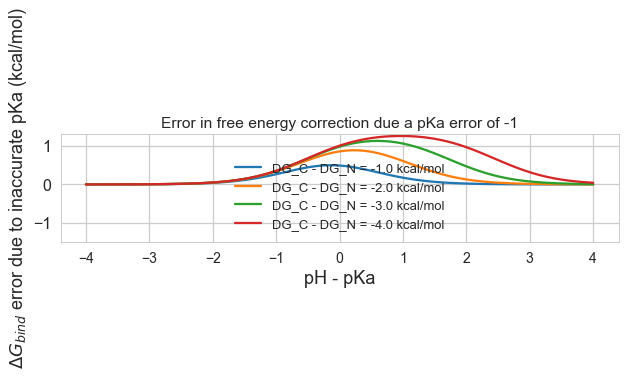

In [5]:
pKa_error = -1
correction.calculate_correction_error_due_to_inaccurate_pKa(pKa_error = pKa_error)

plot_free_energy_correction_error(data = correction.data, x_label = "pH - pKa", 
                                  y_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)", 
                                  DDGs = DDG_values, pKa_error=pKa_error, figsize=(10,2))
#plt.savefig("correction_error_due_to_pKa_error_minus1.pdf")

## Compare correction based on 1 unit underestimated pKa to not correcting

In [6]:
correction.calculate_correction_with_inaccurate_pKa(pKa_error=pKa_error)

,$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$,$\Delta G_{corr}$ (kcal/mol),pH,pH - pKa,pKa,$\Delta G_{corr}$ error (kcal/mol),$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol),$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)
0,-1.0,-0.000261,7.0,4.0,3.0,NaN,0.000235,-0.000026
1,-1.0,-0.000328,7.0,3.9,3.1,NaN,0.000295,-0.000033
2,-1.0,-0.000413,7.0,3.8,3.2,NaN,0.000372,-0.000041
3,-1.0,-0.000520,7.0,3.7,3.3,NaN,0.000468,-0.000052
4,-1.0,-0.000655,7.0,3.6,3.4,NaN,0.000589,-0.000066
5,-1.0,-0.000824,7.0,3.5,3.5,NaN,0.000742,-0.000082
6,-1.0,-0.001037,7.0,3.4,3.6,NaN,0.000933,-0.000104
7,-1.0,-0.001306,7.0,3.3,3.7,NaN,0.001175,-0.000131
8,-1.0,-0.001643,7.0,3.2,3.8,NaN,0.001478,-0.000165
9,-1.0,-0.002067,7.0,3.1,3.9,NaN,0.001860,-0.000207


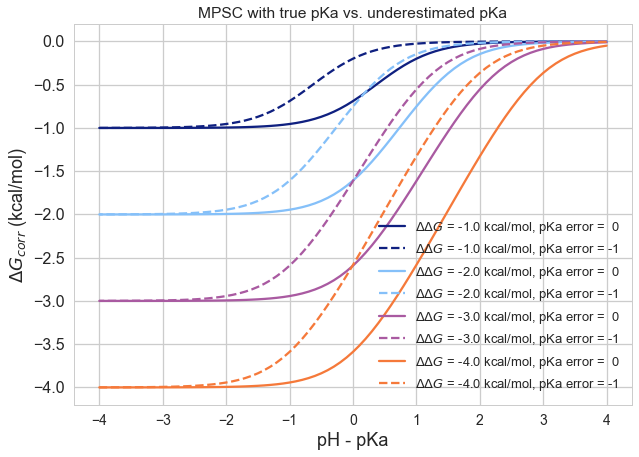

In [7]:
data = correction.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y2_label = "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Zesty colorblind-friendly color palette
color0 = "#0F2080"
color1 = "#85C0F9"
color2 = "#A95AA1"
color3 = "#F5793A"
current_palette = [color0, color1, color2, color3]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = data_1DDG[y1_label]
    y2 = data_1DDG[y2_label]

    # Plot
    plt.plot(x, y1, label = "$\Delta \Delta G $ = {} kcal/mol, pKa error =  0".format(DDG), color=current_palette[i])
    plt.plot(x, y2, linestyle='dashed', label = "$\Delta \Delta G $ = {} kcal/mol, pKa error = {}".format(DDG, pKa_error), color=current_palette[i])


plt.xlabel(x_label)
plt.ylabel(y1_label)
plt.legend()
plt.title("MPSC with true pKa vs. underestimated pKa")
plt.savefig("charged_ligand_binds_better/compare_correction_with_and_without_pKa_error_minus1.pdf")
plt.show()

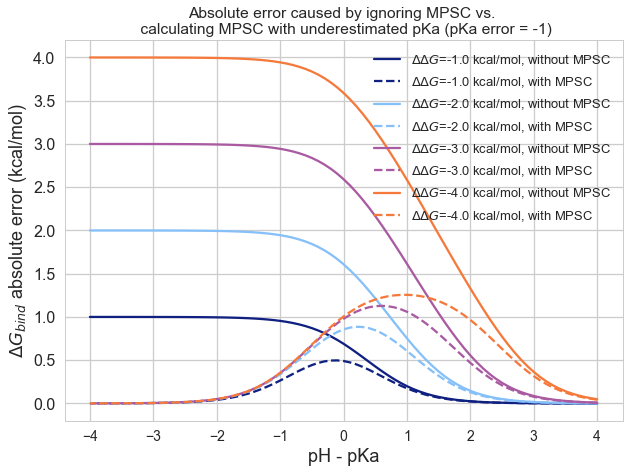

In [8]:
data = correction.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y3_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Zesty colorblind-friendly color palette
color0 = "#0F2080"
color1 = "#85C0F9"
color2 = "#A95AA1"
color3 = "#F5793A"
current_palette = [color0, color1, color2, color3]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = abs(data_1DDG[y1_label])
    y3 = abs(data_1DDG[y3_label])

    # Plot
    plt.plot(x, y1, label = "$\Delta \Delta G $={} kcal/mol, without MPSC".format(DDG), color=current_palette[i])
    plt.plot(x, y3, linestyle='dashed', label = "$\Delta \Delta G $={} kcal/mol, with MPSC".format(DDG, pKa_error), color=current_palette[i])

plt.xlabel(x_label)
plt.ylabel("$\Delta G _{bind}$ absolute error (kcal/mol)")
plt.legend()
plt.title("Absolute error caused by ignoring MPSC vs. \n calculating MPSC with underestimated pKa (pKa error = {})".format(pKa_error))
plt.savefig("charged_ligand_binds_better/compare_absolute_error_ignoring_MPSC_and_MPSC_with_pKa_error_minus1.pdf")
plt.show()

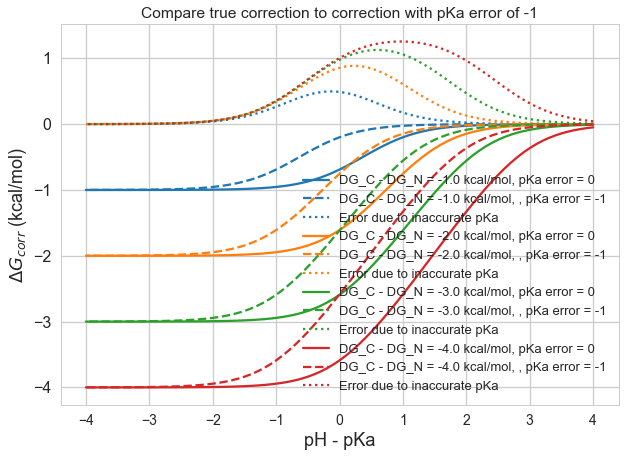

In [9]:
data = correction.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y2_label = "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"
y3_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Color
current_palette = sns.color_palette()
error_color = sns.color_palette("GnBu_d")[0]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = data_1DDG[y1_label]
    y2 = data_1DDG[y2_label]
    y3 = data_1DDG[y3_label]

    # Plot
    plt.plot(x, y1, label = "DG_C - DG_N = {} kcal/mol, pKa error = 0".format(DDG), color=current_palette[i])
    plt.plot(x, y2, linestyle='dashed', label = "DG_C - DG_N = {} kcal/mol, , pKa error = -1".format(DDG), color=current_palette[i])
    plt.plot(x, y3, linestyle='dotted', label = "Error due to inaccurate pKa".format(DDG), color=current_palette[i])

plt.xlabel(x_label)
plt.ylabel(y1_label)
plt.legend()
plt.title("Compare true correction to correction with pKa error of {}".format(pKa_error))
#plt.savefig("compare_correction_with_and_without_pKa_error_minus1.pdf")
plt.show()

## Effects of overestimating pKa by 1 unit

(0, 1.5)

<Figure size 748.8x514.8 with 0 Axes>

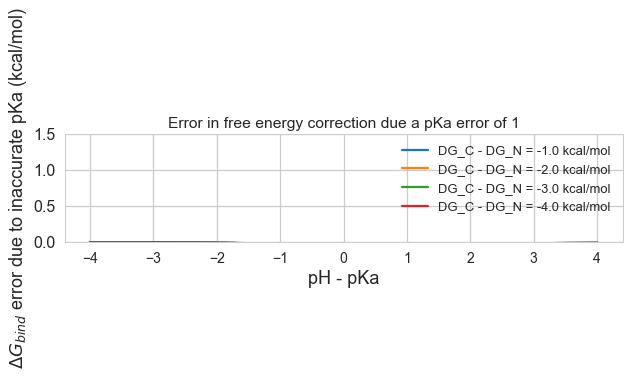

In [10]:
pKa_error = 1
correction2 = correction_to_free_energy_of_binding(DDGs = DDG_values, pH = pH, pKas = pKa_values)
correction2.calculate_correction_error_due_to_inaccurate_pKa(pKa_error = pKa_error)
correction2.calculate_correction_with_inaccurate_pKa(pKa_error=pKa_error)
correction2.calculate_error_due_to_ignoring_correction()

plot_free_energy_correction_error(data = correction2.data, x_label = "pH - pKa", 
                                  y_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)", 
                                  DDGs = DDG_values, pKa_error=pKa_error, figsize=(10,2))
plt.ylim(0,1.5)
#plt.savefig("correction_error_due_to_pKa_error_plus1.pdf")

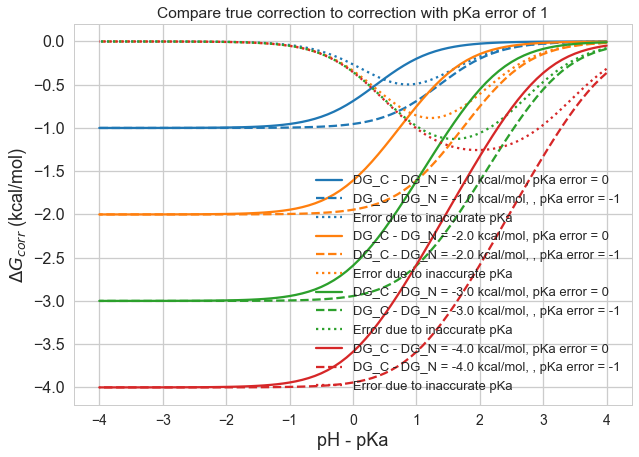

In [11]:
data = correction2.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y2_label = "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"
y3_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Color
current_palette = sns.color_palette()
error_color = sns.color_palette("GnBu_d")[0]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = data_1DDG[y1_label]
    y2 = data_1DDG[y2_label]
    y3 = data_1DDG[y3_label]

    # Plot
    plt.plot(x, y1, label = "DG_C - DG_N = {} kcal/mol, pKa error = 0".format(DDG), color=current_palette[i])
    plt.plot(x, y2, linestyle='dashed', label = "DG_C - DG_N = {} kcal/mol, , pKa error = -1".format(DDG), color=current_palette[i])
    plt.plot(x, y3, linestyle='dotted', label = "Error due to inaccurate pKa".format(DDG), color=current_palette[i])

plt.xlabel(x_label)
plt.ylabel(y1_label)
plt.legend()
plt.title("Compare true correction to correction with pKa error of {}".format(pKa_error))
#plt.savefig("compare_correction_with_and_without_pKa_error_plus1.pdf")
plt.show()

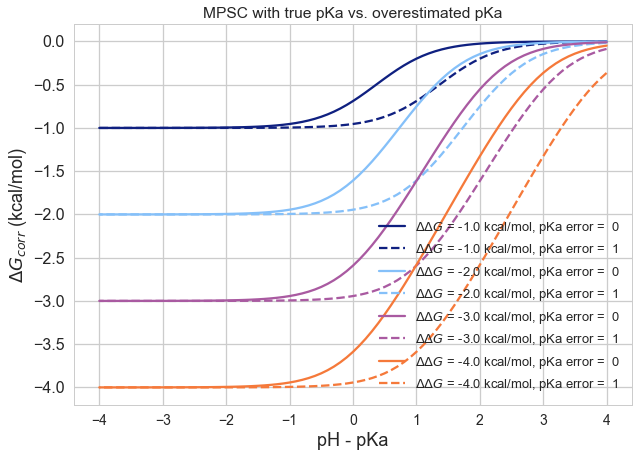

In [12]:
data = correction2.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y2_label = "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Zesty colorblind-friendly color palette
color0 = "#0F2080"
color1 = "#85C0F9"
color2 = "#A95AA1"
color3 = "#F5793A"
current_palette = [color0, color1, color2, color3]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = data_1DDG[y1_label]
    y2 = data_1DDG[y2_label]

    # Plot
    plt.plot(x, y1, label = "$\Delta \Delta G $ = {} kcal/mol, pKa error =  0".format(DDG), color=current_palette[i])
    plt.plot(x, y2, linestyle='dashed', label = "$\Delta \Delta G $ = {} kcal/mol, pKa error =  {}".format(DDG, pKa_error), color=current_palette[i])


plt.xlabel(x_label)
plt.ylabel(y1_label)
plt.legend()
plt.title("MPSC with true pKa vs. overestimated pKa")
plt.savefig("charged_ligand_binds_better/compare_correction_with_and_without_pKa_error_plus1.pdf")
plt.show()

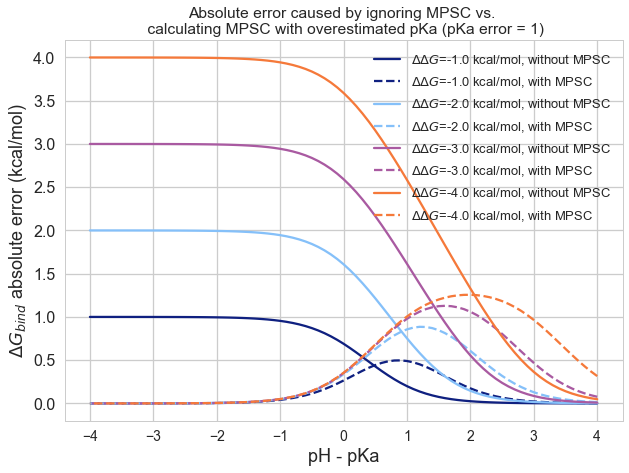

In [13]:
data = correction2.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y3_label = "$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"
DDGs = DDG_values
    
# Zesty colorblind-friendly color palette
color0 = "#0F2080"
color1 = "#85C0F9"
color2 = "#A95AA1"
color3 = "#F5793A"
current_palette = [color0, color1, color2, color3]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = abs(data_1DDG[y1_label])
    y3 = abs(data_1DDG[y3_label])

    # Plot
    plt.plot(x, y1, label = "$\Delta \Delta G $={} kcal/mol, without MPSC".format(DDG), color=current_palette[i])
    plt.plot(x, y3, linestyle='dashed', label = "$\Delta \Delta G $={} kcal/mol, with MPSC".format(DDG, pKa_error), color=current_palette[i])

plt.xlabel(x_label)
plt.ylabel("$\Delta G _{bind}$ absolute error (kcal/mol)")
plt.legend()
plt.title("Absolute error caused by ignoring MPSC vs. \n calculating MPSC with overestimated pKa (pKa error = {})".format(pKa_error))
plt.savefig("charged_ligand_binds_better/compare_absolute_error_ignoring_MPSC_and_MPSC_with_pKa_error_plus1.pdf")
plt.show()

Option1 : add correction based on inaccurate pKa (dashed line)  
          error1 = predicted correction - true correction  

Option2 : ignore correction  
          error2 = 0 - true correction  

How much is the error in option 2 (ignore corr) bigger than error in option 1 (inaccurate pKa)?

error_2_1 = error2 - error1
smaller error_2_1

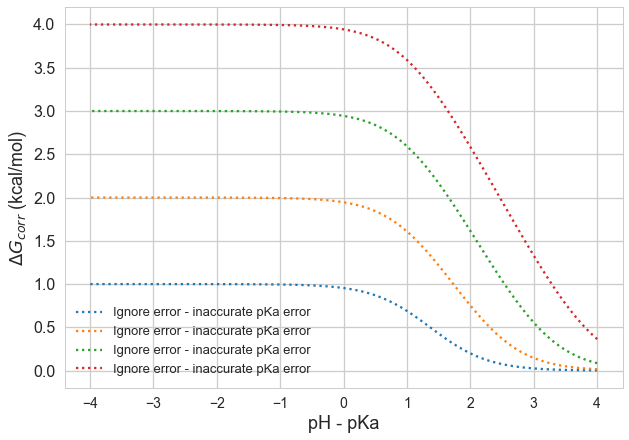

In [14]:
correction2.calc_error_difference_between_ignore_and_inaccurate_pKa()
data = correction2.data
x_label = "pH - pKa"
y1_label = "$\Delta G_{corr}$ (kcal/mol)"
y2_label = "$\Delta G_{corr}$ with inaccurate pKa (kcal/mol)"
y3_label = "$\Delta G_{bind}$ error difference (ignore - inaccurate pKa)"
DDGs = DDG_values
    
# Color
current_palette = sns.color_palette()
error_color = sns.color_palette("GnBu_d")[0]

# Plot style
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.figure(figsize=(10,7))
plt.tight_layout()


#Iterate through DDG values to plot multiple datasets
for i, DDG in enumerate(DDGs):

    # Select data based on DDG specified
    data_1DDG = data[data["$\Delta G_{bind}^{C} - \Delta G_{bind}^{N}$"] == DDG]
    #print("data_1DDG.tail():", data_1DDG.tail())
    x = data_1DDG[x_label]
    y1 = data_1DDG[y1_label]
    y2 = data_1DDG[y2_label]
    y3 = data_1DDG[y3_label]

    # Plot
#   plt.plot(x, y1, label = "DG_C - DG_N = {} kcal/mol, pKa error = 0".format(DDG), color=current_palette[i])
#   plt.plot(x, y2, linestyle='dashed', label = "DG_C - DG_N = {} kcal/mol, , pKa error = -1".format(DDG), color=current_palette[i])
    plt.plot(x, y3, linestyle='dotted', label = "Ignore error - inaccurate pKa error".format(DDG), color=current_palette[i])



plt.xlabel(x_label)
plt.ylabel(y1_label)
plt.legend()
#plt.title("Compare true correction to correction with pKa error of {}".format(pKa_error))
#plt.savefig("compare_errors_due_to_ignoring_correction_vs_inaccurate_pKa_pKa_error-1.pdf")
plt.show()

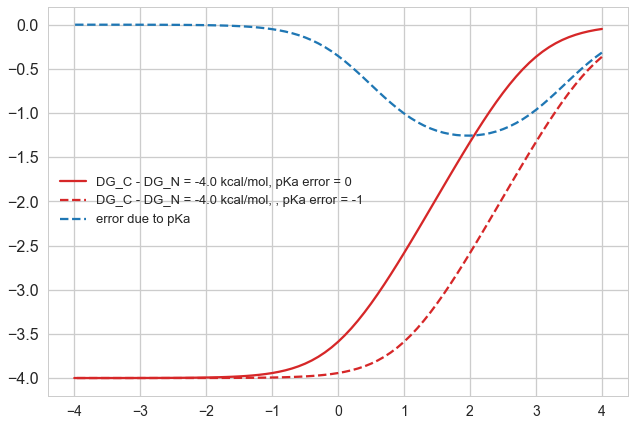

In [15]:
true_correction = y1
pred_correction = y2
plt.plot(x, y1, label = "DG_C - DG_N = {} kcal/mol, pKa error = 0".format(DDG), color=current_palette[i])
plt.plot(x, y2, linestyle='dashed', label = "DG_C - DG_N = {} kcal/mol, , pKa error = -1".format(DDG), color=current_palette[i])
plt.legend()

error_due_to_pKa = pred_correction - true_correction
error_due_to_ignoring = 0 - true_correction

absolute_error_cost_of_ignoring_vs_pKa_error = abs(error_due_to_ignoring) - abs(error_due_to_pKa)

plt.plot(x, error_due_to_pKa,  linestyle='dashed', label = "error due to pKa")
#plt.plot(x, error_due_to_ignoring,  linestyle='solid', label = "error due to ignoring")
#plt.plot(x, absolute_error_cost_of_ignoring_vs_pKa_error,  linestyle='dotted', label = "absolute error cost of ignoring vs pKa error")

plt.legend()

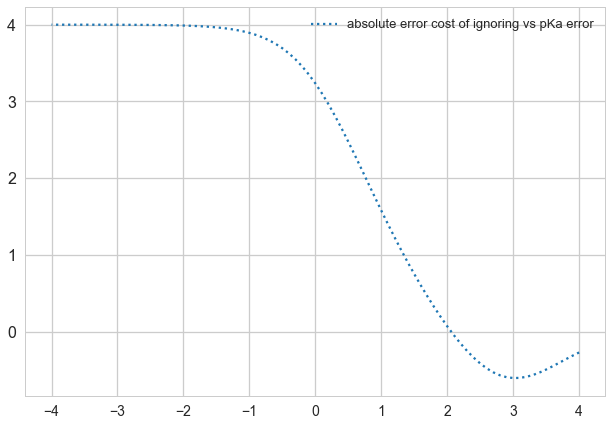

In [16]:
plt.plot(x, absolute_error_cost_of_ignoring_vs_pKa_error,  linestyle='dotted', label = "absolute error cost of ignoring vs pKa error")

plt.legend()

(0, -5)

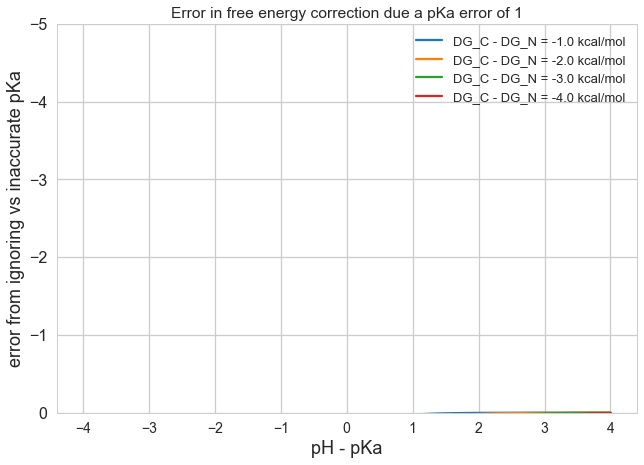

In [17]:
# If you ignore correction how much is it worse than adding a correction with -1 pKa error
df_corr = correction.calculate_error_due_to_ignoring_correction()
df_corr["error from ignoring vs inaccurate pKa"] = np.NaN

for i, row in enumerate(df_corr.iterrows()):
    inaccurate_pKa_error = row[1]["$\Delta G_{bind}$ error due to inaccurate pKa (kcal/mol)"]
    ignoring_correction_error = row[1]["$\Delta G_{bind}$ error if correction is ignored (kcal/mol)"]

    error_difference = ignoring_correction_error - inaccurate_pKa_error
    
    df_corr.loc[i, "error from ignoring vs inaccurate pKa"] = error_difference
    
plot_free_energy_correction_error(data=df_corr, x_label="pH - pKa", y_label = "error from ignoring vs inaccurate pKa", 
                                  DDGs =DDG_values, pKa_error = pKa_error, figsize=False)
plt.ylim(0, -5)